<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/Convolutional_autoencoder_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import TensorFlow and other libraries##

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import tensorflow_datasets as tfds

In [34]:
from tensorflow.keras.optimizers import Adam, SGD

##Connect to google drive##

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Load the dataset##

In [41]:
#create dataset

batch_size = 1000000
img_height = 180
img_width = 180

data_dir = '/content/gdrive/MyDrive/anomaly_detection_task/'

In [42]:
x_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95 files belonging to 1 classes.
Using 76 files for training.


In [43]:
x_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 95 files belonging to 1 classes.
Using 19 files for validation.


##Visualize the data##

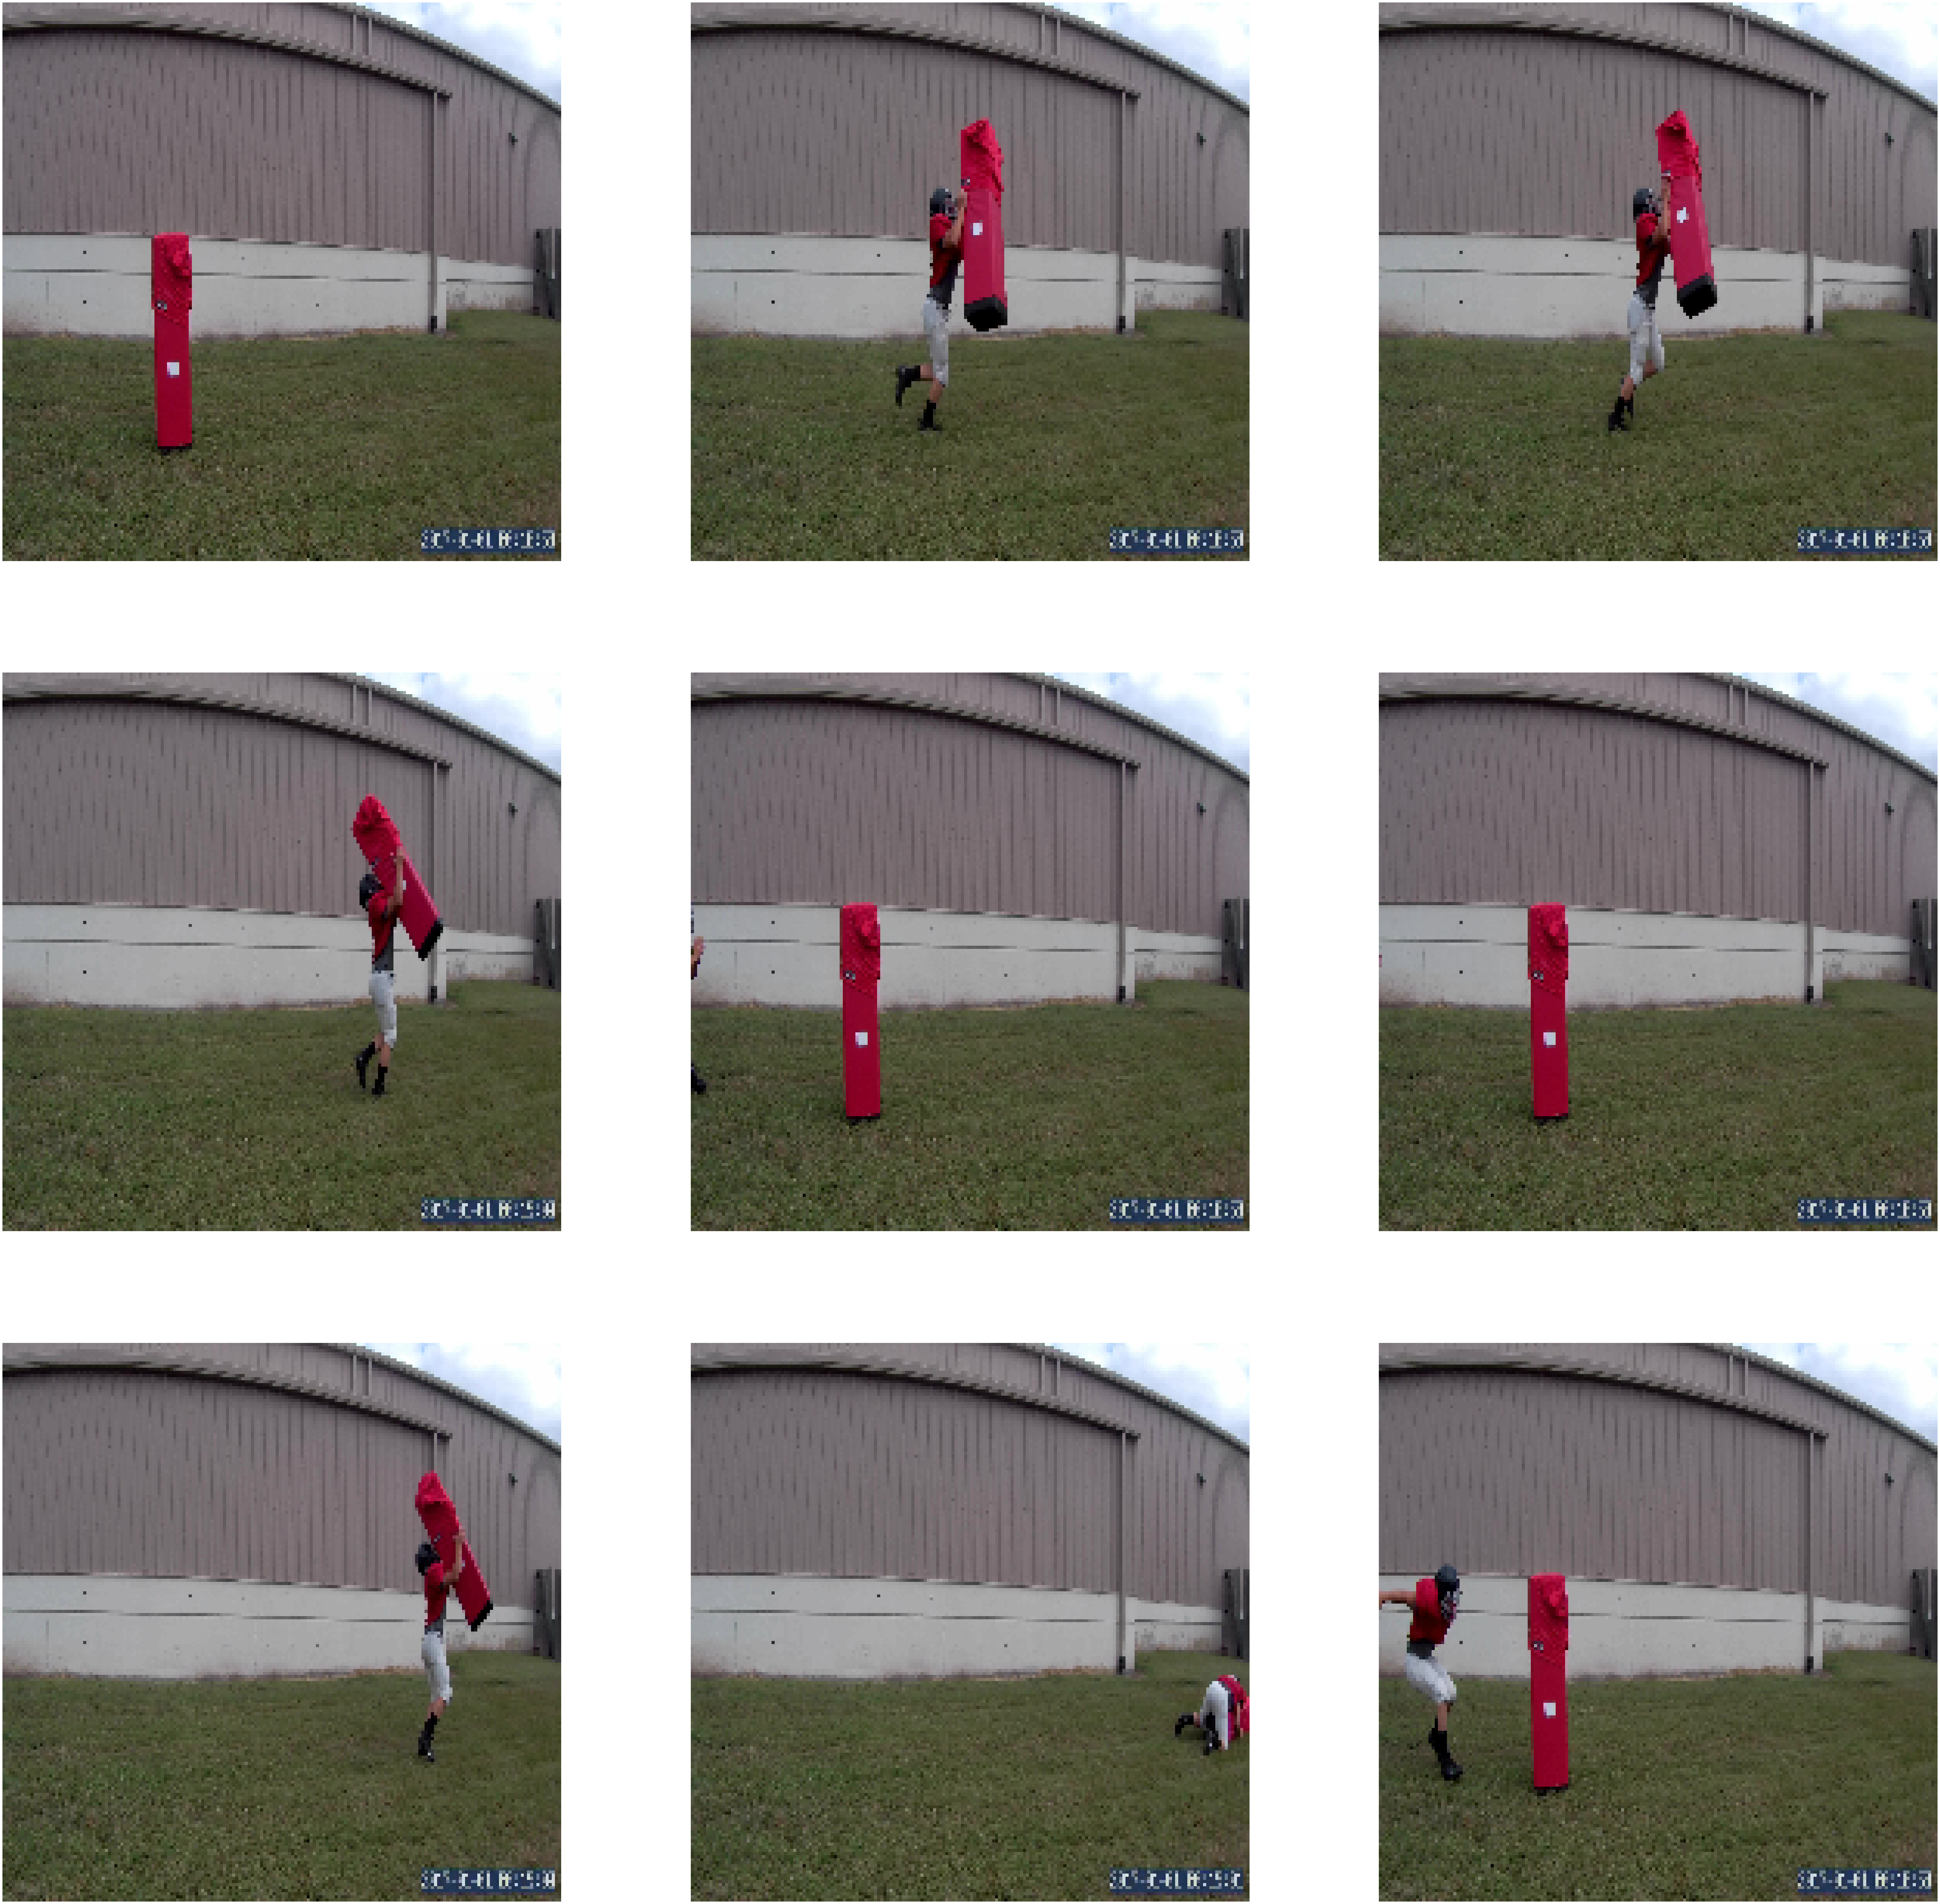

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
for images, labels in x_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

##Convert tf.data.Dataset to Numpy arrays##

In [45]:
import tensorflow_datasets as tfds

In [46]:
x_train = None

for image, label in tfds.as_numpy(x_train_ds):
  print(type(image), type(label), label, len(label))
  x_train = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0] 76
------


In [47]:
x_test = None

for image, label in tfds.as_numpy(x_test_ds):
  print(type(image), type(label), label, len(label))
  x_test = image
  print('------')

<class 'numpy.ndarray'> <class 'numpy.ndarray'> [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 19
------


In [48]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

##Convolutional Autoencoder architecture##

In [49]:
## Hyperparameters
H = 180
W = 180
C = 3

## Latent space
latent_dim = 128

In [50]:
## Building the encoder
inputs = layers.Input(shape=(H, W, C), name="inputs")
x = inputs

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

print('shape after encoder: ', x.shape)

x = layers.Flatten()(x)
units = x.shape[1]
x = layers.Dense(latent_dim, name="latent")(x)


## Building the decoder
x = layers.Dense(units)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((45, 45, 32))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("sigmoid", name="outputs")(x)

outputs = x

shape after encoder:  (None, 45, 45, 32)


In [51]:
print(x.shape)

(None, 180, 180, 3)


In [52]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 90, 90, 32)        128 

In [61]:
autoencoder.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Epoch 1/1000
1/1 [==============================] - 0s 278ms/step - loss: 0.6200 - val_loss: 0.6630
Epoch 2/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.6199 - val_loss: 0.6624
Epoch 3/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.6198 - val_loss: 0.6619
Epoch 4/1000
1/1 [==============================] - 0s 196ms/step - loss: 0.6197 - val_loss: 0.6617
Epoch 5/1000
1/1 [==============================] - 0s 178ms/step - loss: 0.6195 - val_loss: 0.6616
Epoch 6/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.6194 - val_loss: 0.6618
Epoch 7/1000
1/1 [==============================] - 0s 179ms/step - loss: 0.6193 - val_loss: 0.6620
Epoch 8/1000
1/1 [==============================] - 0s 182ms/step - loss: 0.6192 - val_loss: 0.6624
Epoch 9/1000
1/1 [==============================] - 0s 192ms/step - loss: 0.6191 - val_loss: 0.6628
Epoch 10/1000
1/1 [==============================] - 0s 186ms/step - loss: 0.6190 - val_loss: 0.6632

In [62]:
test_pred_y = autoencoder.predict(x_test)

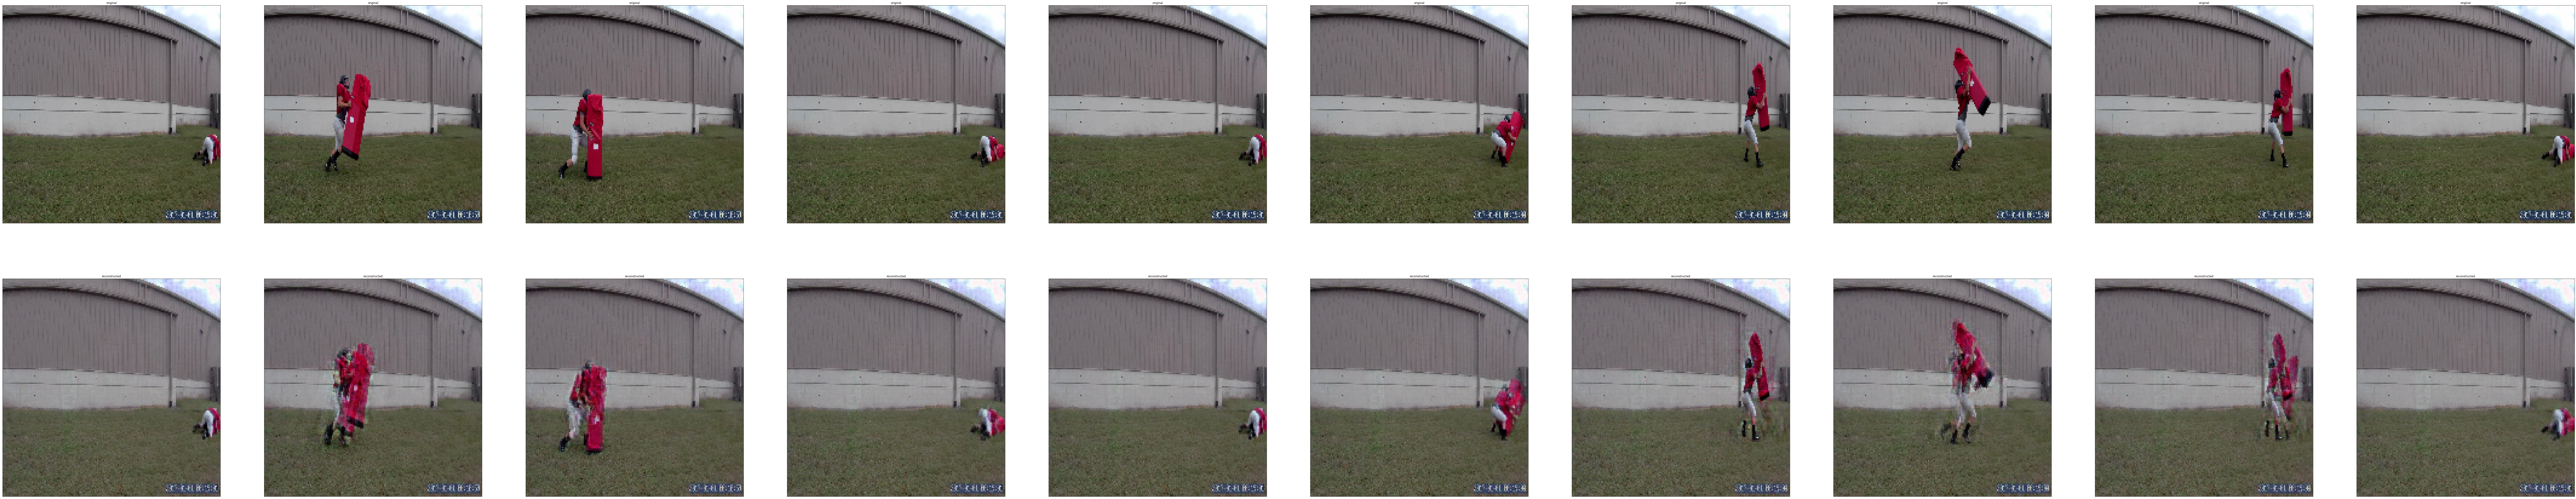

In [64]:
n = 10
plt.figure(figsize=(200, 40))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_pred_y[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()